## Get an idea of our expected tree fragment length distribution given a particular scenario

### imports

In [56]:
import os
import sys
import h5py
import toyplot
import toytree
import numpy as np
import msprime as ms
import subprocess
from __future__ import print_function
from numba import jit
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

### here's our class object from before, which takes a toytree object and runs msprime.

In [40]:
class Coalseq:
    def __init__(
        self, 
        tree,
        dirname,
        theta=0.01,
        nreps=1,
        seed=None,
        debug=False,
        mut=1e-8,
        length=10000,
        recombination_rate=1e-8,
        ):
        # init random seed
        if seed:
            np.random.seed(seed)

        # hidden argument to turn on debugging
        self._debug = debug
        
        self.dirname = dirname
        if not os.path.exists(self.dirname):
            os.mkdir(self.dirname)
            print("Directory '" + self.dirname +  "' created.")
        # store sim params as attrs
        if isinstance(theta, (float, int)):
            self._rtheta = (theta, theta)
        else:
            self._rtheta = (min(theta), max(theta))

        # fixed _mut; _theta sampled from theta; and _Ne computed for diploid
        self._mut = mut
        self._theta = np.random.uniform(self._rtheta[0], self._rtheta[1])
        self._recombination_rate = recombination_rate
        
        # length of chromosome
        self._length = length
        
        # dimension of simulations
        self.nreps = nreps


        # parse the input tree
        if isinstance(tree, toytree.tree):
            self.tree = tree
        elif isinstance(tree, str):
            self.tree = toytree.tree(tree)
        else:
            raise TypeError("input tree must be newick str or Toytree object")
        self.ntips = len(self.tree)

        # store node.name as node.idx, save old names in a dict.
        self.namedict = {}
        for node in self.tree.treenode.traverse():
            if node.is_leaf():
                # store old name
                self.namedict[str(node.idx)] = node.name
                # set new name
                node.name = str(node.idx)

        # parse the input admixture edges. It should a list of tuples, or list
        # of lists where each element has five values.

        ## generate migration parameters from the tree and admixture_edges
        ## stores data in memory as self.test_values as 'mrates' and 'mtimes'
        self._get_test_values()


    @property
    def _Ne(self):
        "Ne is automatically calculated from theta and fixed mut"
        return (self._theta / self._mut) / 4.


    def _get_test_values(self): 

        ## store sampled theta values across ntests
        self._theta = np.random.uniform(
            self._rtheta[0], self._rtheta[1])



    ## functions to build simulation options 
    def _get_demography(self):

        ## Define demographic events for msprime
        demog = set()

        ## tag min index child for each node, since at the time the node is 
        ## called it may already be renamed by its child index b/c of 
        ## divergence events.
        for node in self.tree.treenode.traverse():
            if node.children:
                node._schild = min([i.idx for i in node.get_descendants()])
            else:
                node._schild = node.idx

        ## Add divergence events
        for node in self.tree.treenode.traverse():
            if node.children:
                dest = min([i._schild for i in node.children])
                source = max([i._schild for i in node.children])
                time = node.height * 2. * self._Ne  
                demog.add(ms.MassMigration(time, source, dest))
                if self._debug:
                    print('demog div:', (int(time), source, dest), 
                        file=sys.stderr)


        ## sort events by time
        demog = sorted(list(demog), key=lambda x: x.time)
        return demog


    def _get_popconfig(self):
        """
        returns population_configurations for N tips of a tree
        """
        population_configurations = [
            ms.PopulationConfiguration(sample_size=1, initial_size=self._Ne)
            for ntip in range(self.ntips)]
        return population_configurations


    def _simulate(self):
    
        # store _temp values for this idx simulation, 
        # Ne will be calculated from theta.
        migmat = np.zeros((self.ntips, self.ntips), dtype=int).tolist()
     

        ## build msprime simulation
        #sim = ms.simulate(
        #    length=self._length,
        #    num_replicates=self.nsnps*100,  # 100X since some sims are empty
        #    mutation_rate=self._mut,
        #    migration_matrix=migmat,
        #    population_configurations=self._get_popconfig(),
        #    demographic_events=self._get_demography()
        #)
        ## build msprime simulation
        sim = ms.simulate(
            length=self._length,
            num_replicates=1,  # 100X since some sims are empty
            mutation_rate=self._mut,
            recombination_rate=self._recombination_rate,
            migration_matrix=migmat,
            population_configurations=self._get_popconfig(),
            demographic_events=self._get_demography()
        )
        return sim


    def make_treeseq(self):

        sims = self._simulate()
        self.treeseq = sims.next()
    
    def write_trees(self):
        # make a folder for the msprime genetree files
        dirname_genetrees = self.dirname+'/ms_genetrees'
        if not os.path.exists(dirname_genetrees):
            os.mkdir(dirname_genetrees)
            print("Directory '" + dirname_genetrees +  "' created.")
        
        # make a list to hold onto the sequence lengths associated with each genetree
        lengths = []
        # start a counter for fun (I could enumerate instead...)
        counter = 0
        # for each genetree...
        for tree in self.treeseq.trees():
            # make a new numbered (these are ordered) file containing the newick tree
            with open(dirname_genetrees+'/'+str(counter)+'.phy','w') as f:
                f.write(tree.newick())
            # hold onto the length for this tree
            lengths.append(np.int64(tree.get_length()))
            counter += 1
        
        # save our lengths list as an array to an hdf5 file... I should maybe do this inside the 
        # loop rather than building up a list. 
        lengthsfile = h5py.File(self.dirname+'/ms_genetree_lengths.hdf5','w')
        lengthsfile['lengths'] = np.array(lengths)
        lengthsfile.close()

    def write_seqs(self):
        # make a folder for the sequence files
        dirname_seqs = self.dirname+'/seqs'
        if not os.path.exists(dirname_seqs):
            os.mkdir(dirname_seqs)
            print("Directory '" + dirname_seqs + "' created.")
        # open the file containing the sequence length for each msprime gene tree
        lengthsfile = h5py.File(self.dirname+'/ms_genetree_lengths.hdf5','r')
        
        # for each msprime genetree file...
        for i in os.listdir(self.dirname+'/ms_genetrees'):
            # get the number associated with the genetree file (strip off the '.phy')
            num = i[:-4]
            # get the length of sequence associated with the genetree
            length = str(lengthsfile['lengths'][np.int(num)])
            # run seqgen on the genetree file, using the associated sequence length
            seqgen = subprocess.Popen(['seq-gen', self.dirname +'/ms_genetrees/'+i,'-m','GTR','-l',length, '-s', str(self._mut)], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            # write out a .fa file with number matching the genetree file
            tee = subprocess.Popen(['tee', dirname_seqs+'/'+ num + '.fa'], stdin=seqgen.stdout)
            seqgen.stdout.close()
            # run the command
            tee.communicate()

    def build_seqs(self,
                   filename = 'final_seqs',
                   hdf5=False):
        seq_len = 0
        for i in range(self.treeseq.num_trees):
            with open(self.dirname+'/seqs/' + str(i) + '.fa','r') as f:
                # count up what the total sequence length will be -- just add across all files
                tst = f.read().split('\n')[0]
                try:
                    seq_len += int(tst.split(' ')[2])
                except:
                    print('there was an error: '+tst.split(' '))
        # make a zeros array of the shape of our final alignment
        seq_arr=np.zeros((self.ntips,seq_len),dtype=np.str)
        counter = 0
        # for each simulated sequence fragment...
        for i in range(self.treeseq.num_trees):
            # open the sequence file
            with open(self.dirname+ '/seqs/' + str(i) + '.fa','r') as f:
                # open, split, and exclude the last element (which is extraneous)
                # then sort so that the species are ordered
                myseq = np.sort(f.read().split('\n')[:-1])
                # save the integer length of the sequence fragment from the top line
                lenseq = int(myseq[0].split(' ')[2])
                # now ditch the top line
                myseq = myseq[1:]
                # now add the fragment for each species to the proper place in the array
                for idx, indiv_seq in enumerate(myseq):
                    seq_arr[idx][counter:(counter+lenseq)] = list(indiv_seq[10:])
                counter += lenseq
        # now that we've filled our whole array, we can save it to a full fasta file:
        if not hdf5:
            with open(self.dirname+'/'+filename+'.fa','w') as f:
                # make the header line telling how many taxa and how long the alignment is
                f.write(" "+str(self.ntips)+" "+str(seq_len))
                f.write("\n")
                # for each row of the array, save a taxa ID and then the full sequence.
                for idx, seq in enumerate(seq_arr):
                    # make a line to ID the taxon:
                    f.write(str(idx+1) + ' '*(10-len(str(idx+1))))
                    f.write("\n")
                    #make a line for the sequence
                    f.write(seq)
                    f.write("\n")
        else:
            db=h5py.File(self.dirname+'/'+filename+'.hdf5')
            db['alignment'] = seq_arr
        print("Written full alignment.")

### also go ahead and write a function to get the fragment lengths from the msprime sim...

(These fragment lengths aren't necessarily different topologies, they might be same topology with different branch lengths. But different genealogies)

In [41]:
@jit
def get_dists(breaks):
    num = len(breaks)
    distarr = np.zeros((num-1))
    for i in range(num-1):
        distarr[i]=breaks[i+1]-breaks[i]
    return(distarr)

### make a tree

In [42]:
tree = toytree.rtree.unittree(ntips=9, treeheight=3, seed=42)

### make a class object and run msprime

In [54]:
sim = Coalseq(tree,
            'tester',
           recombination_rate = 1e-10,
           length = 10000000)
sim.make_treeseq()

### plot the distribution of fragment lengths

In [98]:
breaks = np.array(list(sim.treeseq.breakpoints()))
breaks

array([0.00000000e+00, 3.05573456e+03, 3.31245596e+03, ...,
       9.99984126e+06, 9.99995738e+06, 1.00000000e+07])

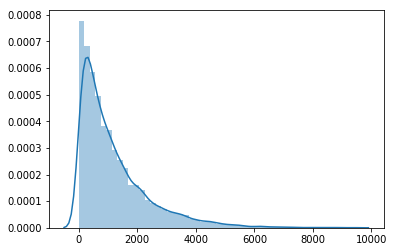

In [99]:
sns.distplot(get_dists(breaks))
plt.show()

### approximate the distribution of fragment lengths using a gaussian kernel density estimator

In [100]:
fragment_lengths = get_dists(np.array(list(sim.treeseq.breakpoints())))

In [101]:
kernel_est = stats.gaussian_kde(fragment_lengths,bw_method=1e-3)

### resample from our estimator to show that the distribution looks similar

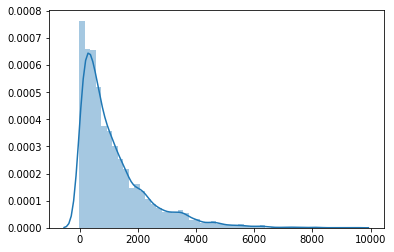

In [102]:
sns.distplot(kernel_est.resample(5000))
plt.show()

### Now compare it to our data:

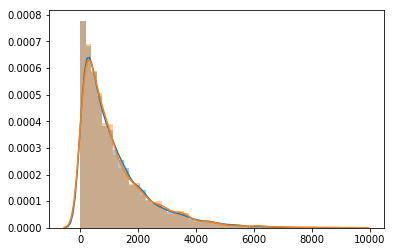

In [103]:
sns.distplot(get_dists(np.array(list(sim.treeseq.breakpoints()))))
sns.distplot(kernel_est.resample(5000))
plt.show()

### What happens when we use trees of different tip numbers?

In [114]:
for i in [4,51]:
    tree = toytree.rtree.unittree(ntips=i, treeheight=3, seed=42)
    sim = Coalseq(tree,
                'tester',
               recombination_rate = 1e-10,
               length = 10000000)
    sim.make_treeseq()
    fivetipkde = stats.gaussian_kde(get_dists(np.array(list(sim.treeseq.breakpoints()))),bw_method=1e-3)
    sns.distplot(fivetipkde.resample(5000))

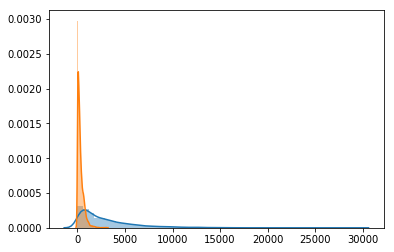

In [115]:
plt.show()

In [116]:
for i in [4,11]:
    tree = toytree.rtree.unittree(ntips=i, treeheight=3, seed=42)
    sim = Coalseq(tree,
                'tester',
               recombination_rate = 1e-10,
               length = 10000000)
    sim.make_treeseq()
    fivetipkde = stats.gaussian_kde(get_dists(np.array(list(sim.treeseq.breakpoints()))),bw_method=1e-3)
    sns.distplot(fivetipkde.resample(5000))

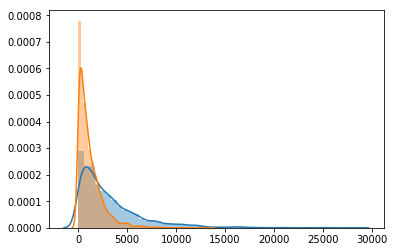

In [117]:
plt.show()

### it's simple to query the gaussian kde...

find the probability that a randomly selected fragment is between two arbitrary values:

In [122]:
fivetipkde.integrate_box(10,100)

0.07267668706275619

evalue the density function at particular values:

In [124]:
fivetipkde.evaluate(100)

array([0.00080963])